In [1]:
from collections import Counter
import pandas as pd
import re
import numpy as np
from bs4 import BeautifulSoup
import requests
import json
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

from sklearn import cluster
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from wordcloud import WordCloud
from gensim.models import Word2Vec
  
%matplotlib inline
from matplotlib import pyplot as plt

# Part 1: Extracting CVE ID Description

In [2]:
df=pd.read_csv("task1.csv")    #Importing and reading dataset
df.head()

,CVE
0,CVE-2020-12712
1,CVE-2020-3956
2,CVE-2020-0796
3,CVE-2020-8617
4,CVE-2020-13166


In [3]:
li=df['CVE'].tolist()            

In [ ]:
l2=[]                                               #Extracting CVE Description
for i in li:
    url="https://nvd.nist.gov/vuln/detail/"+i
    html_content = requests.get(url).text
    soup = BeautifulSoup(html_content)
    l2.append(soup.find("p", {"data-testid": "vuln-description"}).text)

In [ ]:
l3=[]                                               #Finding corresponding Exploit ID 
with open('exploit_cve_map.json') as json_file:
    data = json.load(json_file)
for i in li:
    l3.append(data[i])
for i in range(0,len(l3)):
    l3[i]=l3[i][0]

In [4]:
df['CVE_Description']=l2
df['Exploit_ID']=l3

In [5]:
df.head()                                           

,CVE,CVE_Description,Exploit_ID
0,CVE-2020-12712,A vulnerability based on insecure user/passwor...,48587
1,CVE-2020-3956,"VMware Cloud Director 10.0.x before 10.0.0.2, ...",48540
2,CVE-2020-0796,A remote code execution vulnerability exists i...,48216
3,CVE-2020-8617,"Using a specially-crafted message, an attacker...",48521
4,CVE-2020-13166,The management tool in MyLittleAdmin 3.8 allow...,48513


In [ ]:
df.to_csv('df.csv',index=False)                        #Data exported and saved as CSV file

# Part 2: Extracting Exploit ID and Description

In [2]:
df=pd.read_csv("df.csv")                                       #Importing and reading dataset
li=df['Exploit_ID'].tolist()
l1=[str(int) for int in li]
df.head()

,CVE,CVE_Description,Exploit_ID
0,CVE-2020-12712,A vulnerability based on insecure user/passwor...,48587
1,CVE-2020-3956,"VMware Cloud Director 10.0.x before 10.0.0.2, ...",48540
2,CVE-2020-0796,A remote code execution vulnerability exists i...,48216
3,CVE-2020-8617,"Using a specially-crafted message, an attacker...",48521
4,CVE-2020-13166,The management tool in MyLittleAdmin 3.8 allow...,48513


In [ ]:
title=[]
description=[]                                                 #Extracting title, description,type of attack
types=[]
for i in l1:
    url="https://www.exploit-db.com/exploits/"+i
    headers = {'User-Agent': 'Mozilla/5.0'}
    html_content = requests.get(url,headers=headers).text
    soup = BeautifulSoup(html_content)
    title.append(soup.find("title").text)
    types.append(soup.find("a", href=re.compile("/?type=")).text.strip())
    description.append(str(soup.find("meta",{"name": "description"})).replace("<meta","").replace('name="description"/>',"").replace('"',"").replace('content=',"").strip())

In [ ]:
df['Exploit_Title']=title
df['Exploit_Description']=description
df['Type']=types

In [8]:
df.head()

,CVE,CVE_Description,Exploit_ID,Exploit_Title,Exploit_Description,Type
0,CVE-2020-12712,A vulnerability based on insecure user/passwor...,48587,SOS JobScheduler 1.13.3 - Stored Password Decr...,SOS JobScheduler 1.13.3 - Stored Password Decr...,remote
1,CVE-2020-3956,"VMware Cloud Director 10.0.x before 10.0.0.2, ...",48540,vCloud Director 9.7.0.15498291 - Remote Code E...,vCloud Director 9.7.0.15498291 - Remote Code E...,remote
2,CVE-2020-0796,A remote code execution vulnerability exists i...,48216,Microsoft Windows 10 (1903/1909) - 'SMBGhost' ...,Microsoft Windows 10 (1903/1909) - 'SMBGhost' ...,dos
3,CVE-2020-8617,"Using a specially-crafted message, an attacker...",48521,BIND - 'TSIG' Denial of Service - Multiple dos...,BIND - 'TSIG' Denial of Service. CVE-2020-8617...,dos
4,CVE-2020-13166,The management tool in MyLittleAdmin 3.8 allow...,48513,Plesk/myLittleAdmin - ViewState .NET Deseriali...,Plesk/myLittleAdmin - ViewState .NET Deseriali...,remote


In [ ]:
df.to_csv('df2.csv',index=False)                                   #Data exported and saved as CSV file

# Part 3: Preprocessing

In [80]:
df=pd.read_csv("df2.csv")                                                 #Importing and reading dataset
df["Desc"] = df["CVE_Description"]
des=df['Desc'].tolist()
ty=df['Type'].tolist()

In [81]:
df.head()

,CVE,CVE_Description,Exploit_ID,Exploit_Title,Exploit_Description,Type,Desc
0,CVE-2020-12712,A vulnerability based on insecure user/passwor...,48587,SOS JobScheduler 1.13.3 - Stored Password Decr...,SOS JobScheduler 1.13.3 - Stored Password Decr...,remote,A vulnerability based on insecure user/passwor...
1,CVE-2020-3956,"VMware Cloud Director 10.0.x before 10.0.0.2, ...",48540,vCloud Director 9.7.0.15498291 - Remote Code E...,vCloud Director 9.7.0.15498291 - Remote Code E...,remote,"VMware Cloud Director 10.0.x before 10.0.0.2, ..."
2,CVE-2020-0796,A remote code execution vulnerability exists i...,48216,Microsoft Windows 10 (1903/1909) - 'SMBGhost' ...,Microsoft Windows 10 (1903/1909) - 'SMBGhost' ...,dos,A remote code execution vulnerability exists i...
3,CVE-2020-8617,"Using a specially-crafted message, an attacker...",48521,BIND - 'TSIG' Denial of Service - Multiple dos...,BIND - 'TSIG' Denial of Service. CVE-2020-8617...,dos,"Using a specially-crafted message, an attacker..."
4,CVE-2020-13166,The management tool in MyLittleAdmin 3.8 allow...,48513,Plesk/myLittleAdmin - ViewState .NET Deseriali...,Plesk/myLittleAdmin - ViewState .NET Deseriali...,remote,The management tool in MyLittleAdmin 3.8 allow...


In [82]:
stop_words = stopwords.words("english")                    #Function to remove stop words and lemmatize words are initialized
lemmatizer = WordNetLemmatizer()

In [83]:
def preprocess(text, stem=True):                          # Function to removes link, numbers and special characters
    text = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z]+", ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(lemmatizer.lemmatize(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [84]:
df.Desc = df.Desc.apply(lambda x: preprocess(x))

In [85]:
df.tail()

,CVE,CVE_Description,Exploit_ID,Exploit_Title,Exploit_Description,Type,Desc
195,CVE-2020-28977,The Canto plugin 1.3.0 for WordPress contains ...,49189,Wordpress Plugin Canto 1.3.0 - Blind SSRF (Una...,Wordpress Plugin Canto 1.3.0 - Blind SSRF (Una...,webapps,canto plugin wordpress contains blind ssrf vul...
196,CVE-2020-28976,The Canto plugin 1.3.0 for WordPress contains ...,49189,Wordpress Plugin Canto 1.3.0 - Blind SSRF (Una...,Wordpress Plugin Canto 1.3.0 - Blind SSRF (Una...,webapps,canto plugin wordpress contains blind ssrf vul...
197,CVE-2020-5752,Relative path traversal in Druva inSync Window...,48505,Druva inSync Windows Client 6.6.3 - Local Priv...,Druva inSync Windows Client 6.6.3 - Local Priv...,local,relative path traversal druva insync window cl...
198,CVE-2020-2230,"Jenkins 2.251 and earlier, LTS 2.235.3 and ear...",49237,Jenkins 2.235.3 - 'Description' Stored XSS - J...,Jenkins 2.235.3 - 'Description' Stored XSS. CV...,webapps,jenkins earlier lts earlier escape project nam...
199,CVE-2020-2229,"Jenkins 2.251 and earlier, LTS 2.235.3 and ear...",49232,Jenkins 2.235.3 - 'tooltip' Stored Cross-Site ...,Jenkins 2.235.3 - 'tooltip' Stored Cross-Site ...,webapps,jenkins earlier lts earlier escape tooltip con...


In [86]:
df1=df.copy()

In [87]:
df1=df1.drop(['Exploit_ID','Type','Desc'], axis = 1) 
df1.head()

,CVE,CVE_Description,Exploit_Title,Exploit_Description
0,CVE-2020-12712,A vulnerability based on insecure user/passwor...,SOS JobScheduler 1.13.3 - Stored Password Decr...,SOS JobScheduler 1.13.3 - Stored Password Decr...
1,CVE-2020-3956,"VMware Cloud Director 10.0.x before 10.0.0.2, ...",vCloud Director 9.7.0.15498291 - Remote Code E...,vCloud Director 9.7.0.15498291 - Remote Code E...
2,CVE-2020-0796,A remote code execution vulnerability exists i...,Microsoft Windows 10 (1903/1909) - 'SMBGhost' ...,Microsoft Windows 10 (1903/1909) - 'SMBGhost' ...
3,CVE-2020-8617,"Using a specially-crafted message, an attacker...",BIND - 'TSIG' Denial of Service - Multiple dos...,BIND - 'TSIG' Denial of Service. CVE-2020-8617...
4,CVE-2020-13166,The management tool in MyLittleAdmin 3.8 allow...,Plesk/myLittleAdmin - ViewState .NET Deseriali...,Plesk/myLittleAdmin - ViewState .NET Deseriali...


In [88]:
df=df.drop(['CVE','CVE_Description','Exploit_ID','Exploit_Title','Exploit_Description'], axis = 1) 
df.head()

,Type,Desc
0,remote,vulnerability based insecure user password enc...
1,remote,vmware cloud director x x x x properly handle ...
2,dos,remote code execution vulnerability exists way...
3,dos,using specially crafted message attacker may p...
4,remote,management tool mylittleadmin allows remote at...


In [90]:
df.Type = pd.Categorical(df.Type)
df['Type_Num'] = df.Type.cat.codes
df.head()

,Type,Desc,Type_Num
0,remote,vulnerability based insecure user password enc...,2
1,remote,vmware cloud director x x x x properly handle ...,2
2,dos,remote code execution vulnerability exists way...,0
3,dos,using specially crafted message attacker may p...,0
4,remote,management tool mylittleadmin allows remote at...,2


In [22]:
df1.to_csv('final.csv',index=False)                                       #Data exported and saved as CSV file
df.to_csv('cluster.csv',index=False)

# Part 4: Using Word2Vec and KMeans for Clustering

In [4]:
df=pd.read_csv("cluster.csv")                                             #Importing and reading dataset
documents = [_Body.split() for _Body in df.Desc]

In [5]:
df.head()

,Type,Desc,Type_Num
0,remote,vulnerability based insecure user password enc...,2
1,remote,vmware cloud director x x x x properly handle ...,2
2,dos,remote code execution vulnerability exists way...,0
3,dos,using specially crafted message attacker may p...,0
4,remote,management tool mylittleadmin allows remote at...,2


In [7]:
w2v_model = Word2Vec(documents, size=50, window=3, min_count=4)             #Word2Vec implemented

In [8]:
def average_word_vectors(words, model, vocabulary, num_features):            #Average Document frequency vector extracted
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector

def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)
    

w2v_feature_array = averaged_word_vectorizer(corpus=documents, model=w2v_model, num_features=50)
pd.DataFrame(w2v_feature_array).head()

<ipython-input-8-675dbc3c406e>:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  feature_vector = np.add(feature_vector, model[word])


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.017958,0.219419,-0.036650,-0.185394,-0.044786,0.114071,-0.156690,-0.070767,-0.050607,-0.275538,...,-0.202851,-0.188240,0.008357,-0.015816,0.030452,-0.036396,0.030274,0.093717,0.218923,0.270942
1,0.010022,0.180580,-0.028369,-0.151941,-0.038289,0.094683,-0.126509,-0.057744,-0.043665,-0.224197,...,-0.167023,-0.155274,0.007753,-0.011445,0.029423,-0.029579,0.022066,0.076731,0.178354,0.221756
2,0.012579,0.165364,-0.027554,-0.139125,-0.036537,0.087841,-0.116136,-0.053258,-0.036985,-0.206031,...,-0.153422,-0.146518,0.006470,-0.008468,0.023592,-0.026800,0.022378,0.069919,0.164212,0.205898
3,0.009086,0.138167,-0.022105,-0.113713,-0.028203,0.072166,-0.095702,-0.044761,-0.033761,-0.172029,...,-0.123443,-0.117044,0.004301,-0.009218,0.020954,-0.021999,0.016702,0.056974,0.134599,0.169741
4,0.014212,0.199323,-0.031847,-0.166314,-0.040409,0.104862,-0.140645,-0.065605,-0.047243,-0.246585,...,-0.186121,-0.172416,0.008609,-0.012716,0.028949,-0.030713,0.026552,0.084972,0.197891,0.246578


In [53]:
num_clusters = 4                                           #KMeans model implemented
model =  KMeans(n_clusters = num_clusters).fit(w2v_feature_array)
clusters = model.labels_.tolist()

In [54]:
df['cluster'] = model.predict(w2v_feature_array)

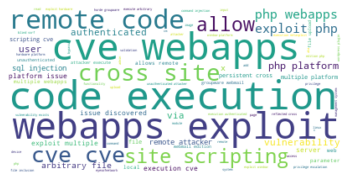

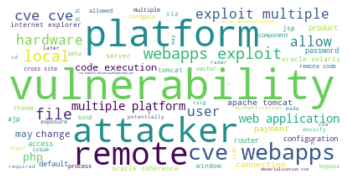

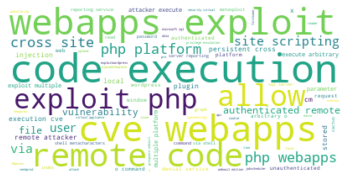

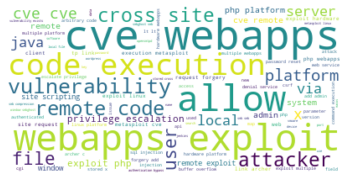

In [55]:
result={'cluster':df['cluster'],'wiki':df['Desc']}         #Word Cloud visualized to validate results
result=pd.DataFrame(result)

for k in range(0,num_clusters):
    s=result[result.cluster==k]
    text=s['wiki'].str.cat(sep=' ')
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)       
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [56]:
pca = PCA(n_components=3)                                           #PCA used to reduce dimentionality for visualization
pca_result = pca.fit_transform(w2v_feature_array)
df['x'] = pca_result[:, 0]
df['y'] = pca_result[:, 1]
df['z'] = pca_result[:, 2]

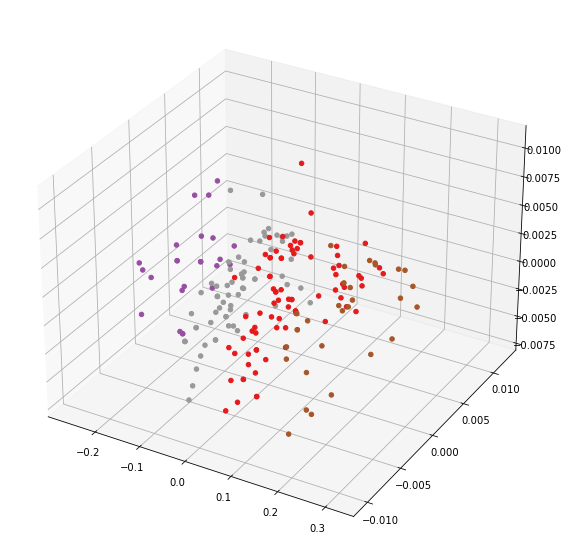

In [57]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d


fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.scatter3D(df.x, df.y, df.z, c=df.cluster, cmap='Set1', depthshade=False)

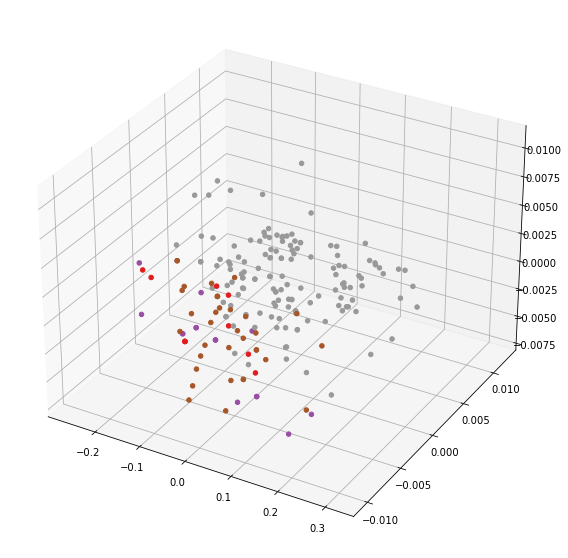

In [58]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.scatter3D(df.x, df.y, df.z, c=df.Type_Num, cmap='Set1', depthshade=False)

In [14]:
df.head()

,Type,Desc,Type_Num,cluster,x,y
0,remote,vulnerability based insecure user password enc...,2,2,0.151276,-0.002324
1,remote,vmware cloud director x x x x properly handle ...,2,3,-0.048740,-0.005976
2,dos,remote code execution vulnerability exists way...,0,3,-0.114736,-0.004654
3,dos,using specially crafted message attacker may p...,0,1,-0.251520,-0.000841
4,remote,management tool mylittleadmin allows remote at...,2,0,0.046442,-0.009230


<AxesSubplot:xlabel='x', ylabel='y'>

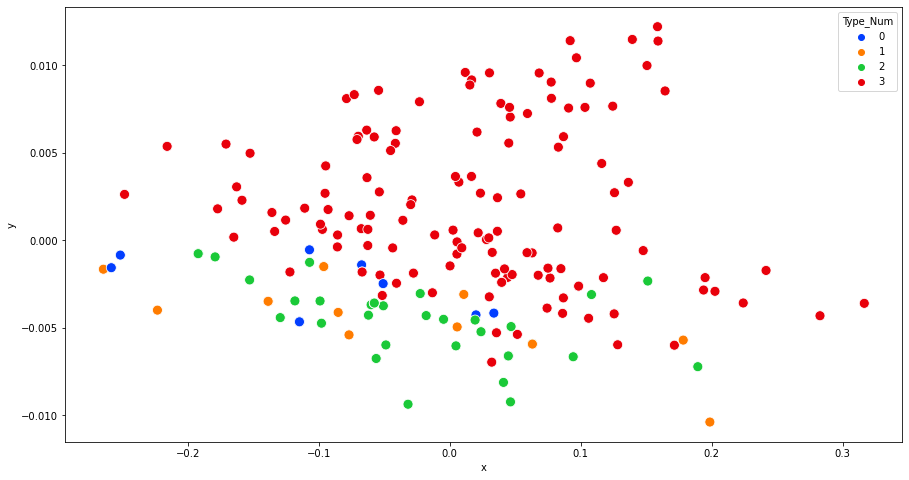

In [15]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=df, x="x", y="y",hue='Type_Num', palette="bright",s=100)

<AxesSubplot:xlabel='x', ylabel='y'>

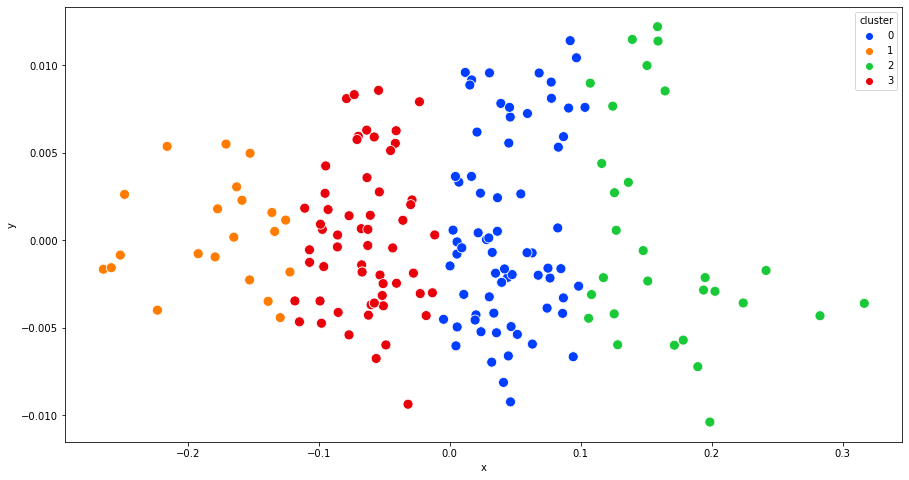

In [16]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=df, x="x", y="y",hue='cluster', palette="bright",s=100)

In [17]:
li=df['cluster']                                                         #Predicted cluster values saved to dataframe 
ddf= pd.read_csv("final.csv") 
ddf["cluster1"]=li
ddf.head()

,CVE,CVE_Description,Exploit_Title,Exploit_Description,cluster1
0,CVE-2020-12712,A vulnerability based on insecure user/passwor...,SOS JobScheduler 1.13.3 - Stored Password Decr...,SOS JobScheduler 1.13.3 - Stored Password Decr...,2
1,CVE-2020-3956,"VMware Cloud Director 10.0.x before 10.0.0.2, ...",vCloud Director 9.7.0.15498291 - Remote Code E...,vCloud Director 9.7.0.15498291 - Remote Code E...,3
2,CVE-2020-0796,A remote code execution vulnerability exists i...,Microsoft Windows 10 (1903/1909) - 'SMBGhost' ...,Microsoft Windows 10 (1903/1909) - 'SMBGhost' ...,3
3,CVE-2020-8617,"Using a specially-crafted message, an attacker...",BIND - 'TSIG' Denial of Service - Multiple dos...,BIND - 'TSIG' Denial of Service. CVE-2020-8617...,1
4,CVE-2020-13166,The management tool in MyLittleAdmin 3.8 allow...,Plesk/myLittleAdmin - ViewState .NET Deseriali...,Plesk/myLittleAdmin - ViewState .NET Deseriali...,0


In [104]:
ddf.to_csv('final1.csv',index=False)                                       #Data exported and saved as CSV file

# Part 5: Using TfIdf and KMeans for Clustering

In [40]:
df=pd.read_csv("cluster.csv")                                               #Importing and reading dataset
df.head()

,Type,Desc,Type_Num
0,remote,vulnerability based insecure user password enc...,2
1,remote,vmware cloud director x x x x properly handle ...,2
2,dos,remote code execution vulnerability exists way...,0
3,dos,using specially crafted message attacker may p...,0
4,remote,management tool mylittleadmin allows remote at...,2


In [41]:
des=df['Desc'].tolist()

In [42]:
vectorizer = TfidfVectorizer(stop_words={'english'})            #TfIdf matrix calculated
X = vectorizer.fit_transform(des)
vocab = vectorizer.get_feature_names()

In [43]:
num_clusters = 4                                                 #KMeans model implemented
model =  KMeans(n_clusters = num_clusters).fit(X)
clusters = model.labels_.tolist()

In [44]:
df['cluster'] = model.predict(X)

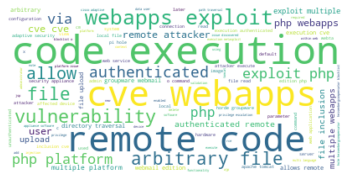

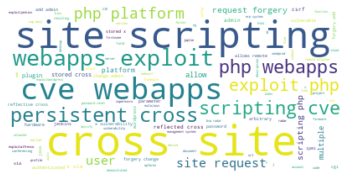

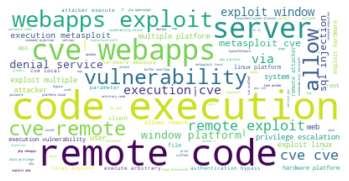

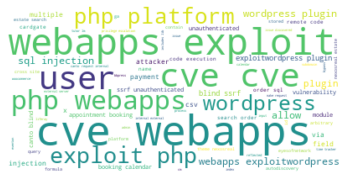

In [45]:
result={'cluster':df['cluster'],'wiki':df['Desc']}              #Word CLoud visualized to validate results
result=pd.DataFrame(result)

for k in range(0,num_clusters):
   s=result[result.cluster==k]
   text=s['wiki'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   titles=df[df.cluster==k]['Type']         
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

In [46]:
pca = TruncatedSVD(n_components=3)                                  #PCA used to reduce dimentionality for visualization
pca_result = pca.fit_transform(X)
df['x'] = pca_result[:, 0]
df['y'] = pca_result[:, 1]
df['z'] = pca_result[:, 2]

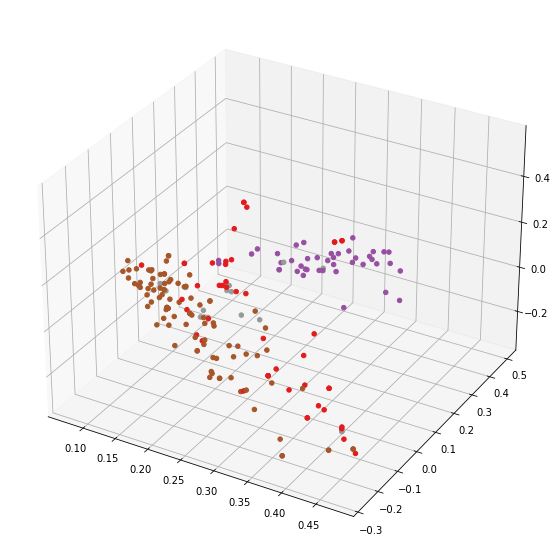

In [47]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d


fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.scatter3D(df.x, df.y, df.z, c=df.cluster, cmap='Set1', depthshade=False)

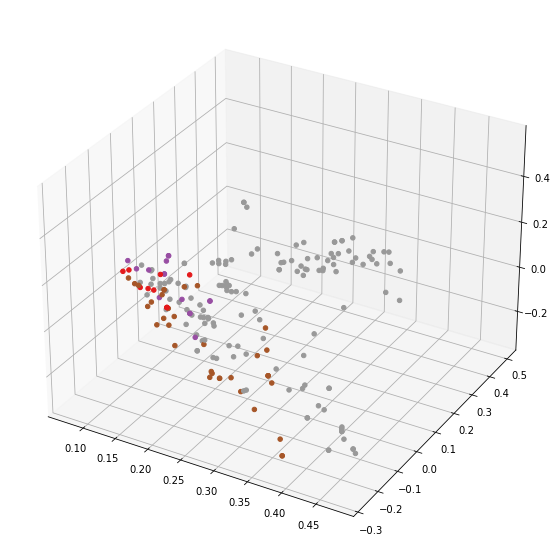

In [48]:
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.scatter3D(df.x, df.y, df.z, c=df.Type_Num, cmap='Set1', depthshade=False)

<AxesSubplot:xlabel='x', ylabel='y'>

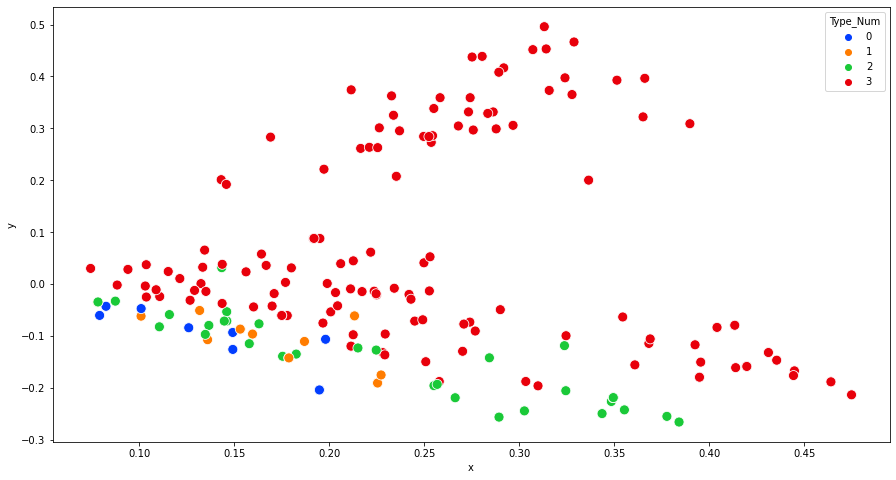

In [25]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=df, x="x", y="y",hue='Type_Num', palette="bright",s=100)

<AxesSubplot:xlabel='x', ylabel='y'>

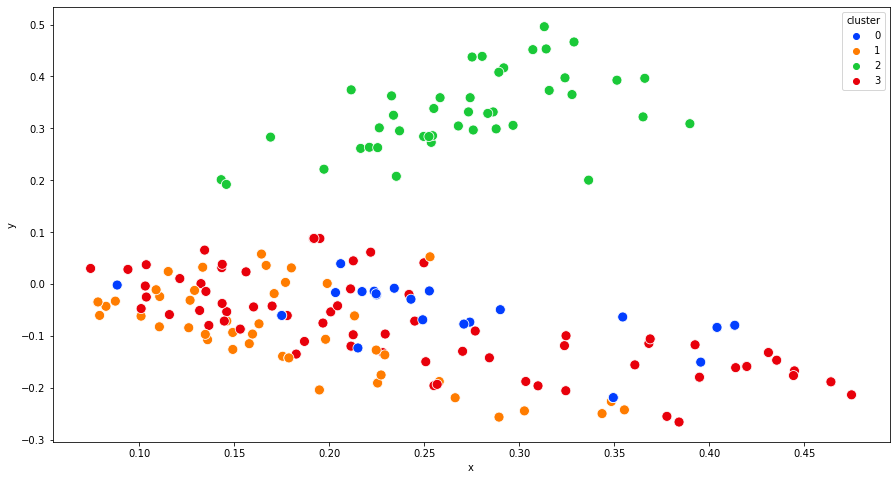

In [26]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=df, x="x", y="y",hue='cluster', palette="bright",s=100)

In [64]:
li=df['cluster']                                                             #Predicted cluster values saved to dataframe 
ddf= pd.read_csv("final1.csv")
ddf["cluster1"]=li
ddf.head()

,CVE,CVE_Description,Exploit_Title,Exploit_Description,cluster1
0,CVE-2020-12712,A vulnerability based on insecure user/passwor...,SOS JobScheduler 1.13.3 - Stored Password Decr...,SOS JobScheduler 1.13.3 - Stored Password Decr...,2
1,CVE-2020-3956,"VMware Cloud Director 10.0.x before 10.0.0.2, ...",vCloud Director 9.7.0.15498291 - Remote Code E...,vCloud Director 9.7.0.15498291 - Remote Code E...,0
2,CVE-2020-0796,A remote code execution vulnerability exists i...,Microsoft Windows 10 (1903/1909) - 'SMBGhost' ...,Microsoft Windows 10 (1903/1909) - 'SMBGhost' ...,3
3,CVE-2020-8617,"Using a specially-crafted message, an attacker...",BIND - 'TSIG' Denial of Service - Multiple dos...,BIND - 'TSIG' Denial of Service. CVE-2020-8617...,3
4,CVE-2020-13166,The management tool in MyLittleAdmin 3.8 allow...,Plesk/myLittleAdmin - ViewState .NET Deseriali...,Plesk/myLittleAdmin - ViewState .NET Deseriali...,0


In [65]:
ddf["cluster1"].replace({1: "WebApps", 0: "Remote",2: "WebApps", 3: "Local/DOS" }, inplace=True)

In [66]:
ddf.head()

,CVE,CVE_Description,Exploit_Title,Exploit_Description,cluster1
0,CVE-2020-12712,A vulnerability based on insecure user/passwor...,SOS JobScheduler 1.13.3 - Stored Password Decr...,SOS JobScheduler 1.13.3 - Stored Password Decr...,WebApps
1,CVE-2020-3956,"VMware Cloud Director 10.0.x before 10.0.0.2, ...",vCloud Director 9.7.0.15498291 - Remote Code E...,vCloud Director 9.7.0.15498291 - Remote Code E...,Remote
2,CVE-2020-0796,A remote code execution vulnerability exists i...,Microsoft Windows 10 (1903/1909) - 'SMBGhost' ...,Microsoft Windows 10 (1903/1909) - 'SMBGhost' ...,Local/DOS
3,CVE-2020-8617,"Using a specially-crafted message, an attacker...",BIND - 'TSIG' Denial of Service - Multiple dos...,BIND - 'TSIG' Denial of Service. CVE-2020-8617...,Local/DOS
4,CVE-2020-13166,The management tool in MyLittleAdmin 3.8 allow...,Plesk/myLittleAdmin - ViewState .NET Deseriali...,Plesk/myLittleAdmin - ViewState .NET Deseriali...,Remote


In [79]:
ddf.to_csv('final2.csv',index=False)                                                       #Data exported and saved as CSV file